In [1]:
from tensorflow import keras
from tensorflow.keras import layers
# keras or tensorflow.keras? Long story short, one should use tensorflow.keras
# if there isn't any backward-compatibility concern

import json
import numpy as np
import tensorflow as tf

IMG_DIR = 'files/images-2cat'

Take a look at my poor little GPU ¯\\_(ツ)_/¯

In [2]:
from subprocess import Popen, PIPE

process = Popen(['nvidia-smi'], stdout=PIPE)
(output, err) = process.communicate()
exit_code = process.wait()
print(output.decode('utf8'))

Fri Dec 10 23:01:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 496.13       Driver Version: 496.13       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:02:00.0 Off |                  N/A |
| N/A   55C    P8    N/A /  N/A |     64MiB /  2048MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
seed = 666
image_size = (256, 256)
# Size to resize images to after they are read from disk.
# Defaults to (256, 256). Since the pipeline processes batches
# of images that must all have the same size, this must be provided. 
batch_size = 4

validation_split=0.33
# float between 0 and 1, fraction of data to reserve for validation. 

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=IMG_DIR,
    validation_split=validation_split,
    subset="training",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=IMG_DIR,
    validation_split=validation_split,
    subset="validation",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
)

Found 6531 files belonging to 2 classes.
Using 4376 files for training.
Found 6531 files belonging to 2 classes.
Using 2155 files for validation.


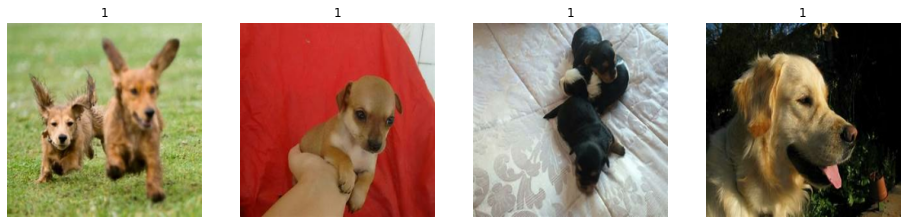

In [5]:
# Visualize the data
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 9))
for images, labels in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(1, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [6]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

In [8]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Dense(128, activation="ReLU")(x)
    x = layers.Dropout(0.4)(x)
    x = tf.keras.layers.Flatten()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=2)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 dense (Dense)               (None, 256, 256, 128)     512       
                                                                 
 dropout (Dropout)           (None, 256, 256, 128)     0         
                                                                 
 flatten (Flatten)           (None, 8388608)           0         
                                                                 
 dropout_1 (Dropout)         (None, 8388608)           0         
                                                                 
 dense_1 (Dense)             (None, 1)                 838860

### Understanding of the `Output Shape`
`None` means a dynamic dimension of a batch (mini batch). This is why you can set any batch size to your model.

Another way of to explain `None` is that a `None` dimension means that it can be any scalar number, so that you use this model to infer on an arbitrarily long input. This dimension does not affect the size of the network, it just denotes that you are free to select the length (number of samples) of your input during testing.

The remaining elements of the shape tuple is the shape of the corresponding tensor.

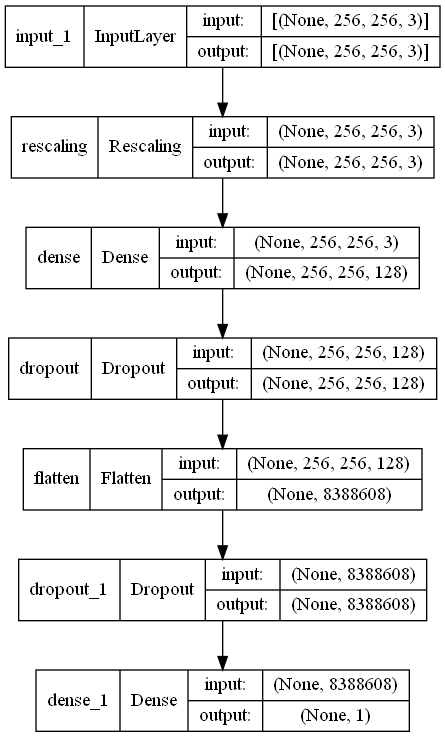

In [9]:
keras.utils.plot_model(model, show_shapes=True)

In [10]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(train_ds, epochs=50, validation_data=val_ds)
# validation_data: Data on which to evaluate the loss and any model metrics at the end of each epoch. The model will not be trained on this data. 

Epoch 1/50
1094/1094 [==============================] - 224s 204ms/step - loss: 1.5093 - accuracy: 0.7173 - val_loss: 0.8361 - val_accuracy: 0.6979
Epoch 2/50
1094/1094 [==============================] - 225s 205ms/step - loss: 0.5647 - accuracy: 0.7482 - val_loss: 0.6162 - val_accuracy: 0.7104
Epoch 3/50
1094/1094 [==============================] - 224s 205ms/step - loss: 0.5591 - accuracy: 0.7500 - val_loss: 0.6388 - val_accuracy: 0.7197
Epoch 4/50
1094/1094 [==============================] - 225s 205ms/step - loss: 0.5430 - accuracy: 0.7530 - val_loss: 0.6119 - val_accuracy: 0.7137
Epoch 5/50
1094/1094 [==============================] - 224s 205ms/step - loss: 0.5361 - accuracy: 0.7553 - val_loss: 0.6155 - val_accuracy: 0.7239
Epoch 6/50
1094/1094 [==============================] - 225s 205ms/step - loss: 0.5292 - accuracy: 0.7578 - val_loss: 0.5950 - val_accuracy: 0.7234
Epoch 7/50
1094/1094 [==============================] - 224s 205ms/step - loss: 0.5058 - accuracy: 0.7694 - val_